# Notebook zawierający autorski algorytm, który służy do rozpoznawania religii której dotyczy tekst.

Celem jest stworzenie algorytmu który w miarę szybko będzie w stanie rozpoznać z dostateczną dokładnością religię której dotyczy dany post tylko i wyłącznie na podstawie treści tego posta. Na koniec również przetestujemy algorytm ("uczony" na  postach) na komentarzach w celu sprawdzenia jak dobrze radzi sobie z tekstami które są krótsze i często nie zawierają tyle słów charakterystycznych co Posty

Najpierw importujemy wszystkie funkcje i klasę religion z modułu utils, które sami napisaliśmy (dokładniejszy opis działania można znaleźć w docstringach w utils.py) oraz Counter który przyda nam się później

In [1]:
from utils import *
from collections import Counter
import matplotlib.pyplot as plt

Z pomocą konstruktora klasy Religion pobieramy wszystkie dane z plików. W argumentach konstruktorów należy podać ścieżki do folderów w których są poszczególne źródłowe pliki .xml. w moim przypadku w jednym folderze znajduje się repozytorium, oraz 3 katalogi z poszczególnymi plikami. Następnie używamy metody clear_html_attrs która tworzy nam nowe kolumny w dataframe'ach Raligion.Posts i Religion.Comments z 'oczyszczoną' treścią komentarzy i postów (bez znaczników html oraz znaków interpunkcyjnych)

In [2]:
buddyzm = Religion('../buddyzm')
islam = Religion('../islam')
judaism = Religion('../judaism')

In [3]:
islam.clear_html_attrs()
buddyzm.clear_html_attrs()
judaism.clear_html_attrs()

Teraz Łączymy treści postów z danej religii do jednego długiego stringa z którego będziemy następnie wybierać słowa kluczowe.

In [4]:
big_islam_string=" ".join([t for t in islam.Posts['clear_body'] if type(t)==str])
big_buddyzm_string=" ".join([t for t in buddyzm.Posts['clear_body'] if type(t)==str])
big_judaism_string=" ".join([t for t in judaism.Posts['clear_body'] if type(t)==str])

Próbowaliśmy w tym miejscu skorzystać z jednej z gotowych implementacji algorytmu Rake oraz tf-idf, jednak okazało się, że obydwa algorytmy działają dobrze tylko przy jednym alfabecie. Gdy natykały się na frazę w alfabecie innym niż łaciński (np cytat z koranu lub tory), brały całą jako jedno wyrażenie i nie potrafiliśmy sobie z tym poradzić. Uznaliśmy że na potrzeby tego projektu napiszemy własny (prawdopodobnie nie najlepszy) kod generujący słowa kluczowe z tekstu używając Countera

In [5]:
judaism_words = big_judaism_string.lower().split()
islam_words = big_islam_string.lower().split()
buddyzm_words = big_buddyzm_string.lower().split()

In [6]:
judaism_wc= len(judaism_words)
judaism_counter = Counter(judaism_words)
islam_wc= len(islam_words)
islam_counter = Counter(islam_words)
buddyzm_wc= len(buddyzm_words)
buddyzm_counter = Counter(buddyzm_words)


W tym momencie zabraliśmy się za pisanie algorytmu który w jakiś sposób oceniał który string gdzie pasuje biorąc pod uwagę słowa kluczowe. Pierwsza wersja polegała na tym, że iterując po wszystkich słowach w poście dla każdej religii osobno dodajemy ich częstość a następnie zwracamy religię dla której suma ta jest największa tworzę też prostą funkcję do porównywania dokładności działania algorytmu dla poszczególnych religii.

In [7]:
def which_religion(string):
    judaism_score = 0
    islam_score = 0
    buddyzm_score = 0
    for word in string.lower().split():
        judaism_score+=judaism_counter[word]*100/judaism_wc
        islam_score+=islam_counter[word]*100/islam_wc
        buddyzm_score+=buddyzm_counter[word]*100/buddyzm_wc
    
    #return judaism_score, islam_score, buddyzm_score #for debugging
    if judaism_score>=islam_score and judaism_score>=buddyzm_score:
        return 'judaism'
    elif islam_score>=buddyzm_score:
        return 'islam'
    return 'buddyzm'

def show_accuracy(judaism_accuracy, buddyzm_accuracy, islam_accuracy):
    plt.bar([0,1,2],[judaism_accuracy, buddyzm_accuracy, islam_accuracy],color='#BC4ABA')
    plt.xticks([0,1,2],['judaism','buddyzm', 'islam'])
    plt.xlabel('Religia', fontsize=12, color='#323232')
    plt.ylabel('dokładność algorytmu', fontsize=12, color='#323232')
    plt.title('Dokładność algorytmu dla poszczególnych religii', fontsize=16, color='#323232')
    plt.show

Jak widać poniżej, skuteczność naszego algorytmu pozostawiała wiele do życzenia. Po analizie postów i częstości odpowiednich słów w poszczególnych religiach doszliśmy do wniosku, że największy wpływ mają słowa najczęstsze w angielskim a nie najbardziej charakterystyczne dla danej religii. W związku z tym otrzymaliśmy algorytm który dla większości angielskich tekstów zwracał 'buddyzm'.

islam accuracy: 17.161726600518232%
judaism accuracy: 37.973932297016596%
buddyzm accuracy: 94.88456033356152%


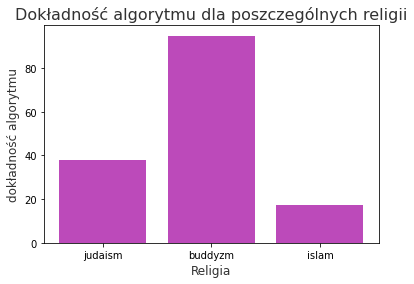

In [8]:
islam_good=0
judaism_good=0
buddyzm_good=0

for string in islam.Posts['clear_body']:
    if which_religion(string)=='islam':
        islam_good+=1
        
for string in judaism.Posts['clear_body']:
    if which_religion(string)=='judaism':
        judaism_good+=1
        
for string in buddyzm.Posts['clear_body']:
    if which_religion(string)=='buddyzm':
        buddyzm_good+=1
accuracy=[judaism_good/len(judaism.Posts)*100, buddyzm_good/len(buddyzm.Posts)*100, islam_good/len(islam.Posts)*100]
print(f'islam accuracy: {accuracy[2]}%')
print(f'judaism accuracy: {accuracy[0]}%')
print(f'buddyzm accuracy: {accuracy[1]}%')
show_accuracy(*accuracy)
        
        

Naszym pierwszym pomysłem na rozwiązanie tego problemu było nie uwzględnianie naczęstszych słów w języku angielskim. Wzieliśmy je z pliku znalezionego w internecie, jednak można go tu łatwo podmienić, lub dodać do niego więcej słów

In [9]:
stopwords = []
with open('../stopwords.txt') as file: #https://gist.github.com/sebleier/554280
    for line in file:
        stopwords.append(line[:-1])
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

Należało teraz zmniejszyć obliczaną wcześniej ilość słów w długich stringach tak, aby nie uwzględniała słów z pliku wyżej

In [10]:
judaism_wc= len([word for word in judaism_words if word not in stopwords])
islam_wc= len([word for word in islam_words if word not in stopwords])
buddyzm_wc= len([word for word in buddyzm_words if word not in stopwords])

Skopiowaliśmy naszą funkcję z nową nazwą i dodatkową linijką kodu

In [11]:
def which_religion_with_stopwords(string):
    judaism_score = 0
    islam_score = 0
    buddyzm_score = 0
    for word in string.lower().split():
        if word not in stopwords: #Jedyna zmiana względem poprzedniego algorytmu
            judaism_score+=judaism_counter[word]*100/judaism_wc
            islam_score+=islam_counter[word]*100/islam_wc
            buddyzm_score+=buddyzm_counter[word]*100/buddyzm_wc
    
    #return judaism_score, islam_score, buddyzm_score #for debugging
    if judaism_score>=islam_score and judaism_score>=buddyzm_score:
        return 'judaism'
    elif islam_score>=buddyzm_score:
        return 'islam'
    return 'buddyzm'

Jak widać wyniki są zdecydowanie lepsze niż pierwsza wersja algorytmu, jednak dalej widać rażące różnice między religiami

islam accuracy: 90.88352398407382%
judaism accuracy: 66.82987513981146%
buddyzm accuracy: 97.60408239467297%


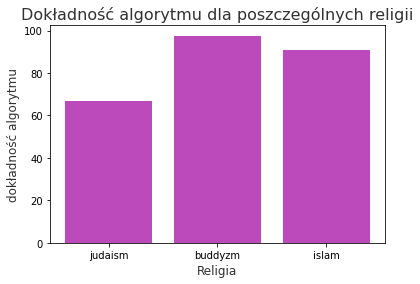

In [12]:
islam_good=0
judaism_good=0
buddyzm_good=0

for string in islam.Posts['clear_body']:
    if which_religion_with_stopwords(string)=='islam':
        islam_good+=1
        
for string in judaism.Posts['clear_body']:
    if which_religion_with_stopwords(string)=='judaism':
        judaism_good+=1
        
for string in buddyzm.Posts['clear_body']:
    if which_religion_with_stopwords(string)=='buddyzm':
        buddyzm_good+=1
        
accuracy=[judaism_good/len(judaism.Posts)*100, buddyzm_good/len(buddyzm.Posts)*100, islam_good/len(islam.Posts)*100]
print(f'islam accuracy: {accuracy[2]}%')
print(f'judaism accuracy: {accuracy[0]}%')
print(f'buddyzm accuracy: {accuracy[1]}%')
show_accuracy(*accuracy)        
        

Stworzyliśmy więc kolejną wersję algorytmu, również uwzględniającą stopwords, jednak zmieniliśmy również podstawową zasadę działania. Teraz algorytm przyznaje punkt danej religii jeżeli jakieś słowo pojawia się co najmniej 2 razy częściej w postach danej religii niż średnio w postach pozostałych religii. współczynnik 2 jest arbitralny i potem jeszcze spróbujemy go zoptymalizować

In [13]:
def another_which_religion_with_stopwords(string, wsp = 2):
    judaism_score = 0
    islam_score = 0
    buddyzm_score = 0
    for word in string.lower().split():
        if word not in stopwords:
            j, i, b = judaism_counter[word]*100/judaism_wc,\
            islam_counter[word]*100/islam_wc, \
            buddyzm_counter[word]*100/buddyzm_wc 
            if j>(i+b)*(wsp/2):
                judaism_score+=1
            elif i>(j+b)*(wsp/2):
                islam_score+=1
            elif b>(j+i)*(wsp/2):
                buddyzm_score+=1
    
    #return judaism_score, islam_score, buddyzm_score #for debugging
    if judaism_score>=islam_score and judaism_score>=buddyzm_score:
        return 'judaism'
    elif islam_score>=buddyzm_score:
        return 'islam'
    return 'buddyzm'

islam accuracy: 93.27561145168426%
judaism accuracy: 94.70656714373759%
buddyzm accuracy: 98.5500031115813%


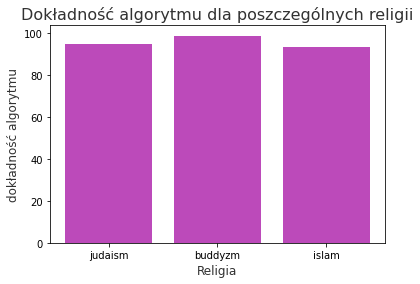

In [14]:
islam_good=0
judaism_good=0
buddyzm_good=0

for string in islam.Posts['clear_body']:
    if another_which_religion_with_stopwords(string)=='islam':
        islam_good+=1
        
for string in judaism.Posts['clear_body']:
    if another_which_religion_with_stopwords(string)=='judaism':
        judaism_good+=1
        
for string in buddyzm.Posts['clear_body']:
    if another_which_religion_with_stopwords(string)=='buddyzm':
        buddyzm_good+=1
        
accuracy=[judaism_good/len(judaism.Posts)*100, buddyzm_good/len(buddyzm.Posts)*100, islam_good/len(islam.Posts)*100]
print(f'islam accuracy: {accuracy[2]}%')
print(f'judaism accuracy: {accuracy[0]}%')
print(f'buddyzm accuracy: {accuracy[1]}%')
show_accuracy(*accuracy)
        

Jak widać wyniki są już wystarczające żeby powiedzieć, że algorytm działa. Jak widać poniżej, radzi sobie w miarę dobrze również z komentarzami

In [15]:
islam_good=0
judaism_good=0
buddyzm_good=0

for string in islam.Comments['clear_text']:
    if another_which_religion_with_stopwords(string)=='islam':
        islam_good+=1
        
for string in judaism.Comments['clear_text']:
    if another_which_religion_with_stopwords(string)=='judaism':
        judaism_good+=1
        
for string in buddyzm.Comments['clear_text']:
    if another_which_religion_with_stopwords(string)=='buddyzm':
        buddyzm_good+=1
        
print(f'islam percentage: {islam_good/len(islam.Comments)*100}%')
print(f'judaism percentage: {judaism_good/len(judaism.Comments)*100}%')
print(f'buddyzm percentage: {buddyzm_good/len(buddyzm.Comments)*100}%')

islam percentage: 70.3065917220235%
judaism percentage: 83.19560361813015%
buddyzm percentage: 82.59315206445116%


Teraz Postaramy się znaleźć najlepszy współczynnik do naszego algorytmu. Sprawdzimy wszystkie liczby z dokładnością do 1.1 od 1.1 do 10. 

In [16]:
best=0
for wsp in range(11,101):
    islam_good=0
    judaism_good=0
    buddyzm_good=0

    for string in islam.Posts['clear_body'][:3000]:
        if another_which_religion_with_stopwords(string, wsp/10)=='islam':
            islam_good+=1
        
    for string in judaism.Posts['clear_body'][:3000]:
        if another_which_religion_with_stopwords(string, wsp/10)=='judaism':
            judaism_good+=1
        
    for string in buddyzm.Posts['clear_body'][:3000]:
        if another_which_religion_with_stopwords(string, wsp/10)=='buddyzm':
            buddyzm_good+=1
    k = (islam_good+judaism_good+buddyzm_good)/3000
    if k>best:
        best=k
        best_wsp = wsp/10
print(f'najlepszy współczynnik to {best_wsp}')
print(f'osiągnął średnią skuteczność {best*100/3}% w ocenianu postów')

najlepszy współczynnik to 8.6
osiągnął średnią skuteczność 97.78888888888889% w ocenianu postów


islam accuracy: 66.61727133367398%
judaism accuracy: 97.61958627611483%
buddyzm accuracy: 75.05287009063444%


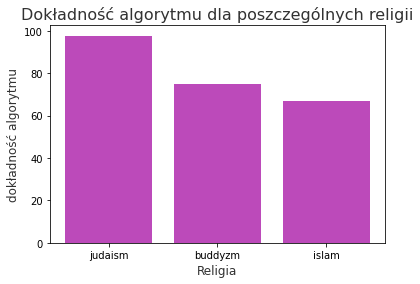

In [17]:
islam_good=0
judaism_good=0
buddyzm_good=0

for string in islam.Comments['clear_text']:
    if another_which_religion_with_stopwords(string, best_wsp)=='islam':
        islam_good+=1
        
for string in judaism.Comments['clear_text']:
    if another_which_religion_with_stopwords(string, best_wsp)=='judaism':
        judaism_good+=1
        
for string in buddyzm.Comments['clear_text']:
    if another_which_religion_with_stopwords(string, best_wsp)=='buddyzm':
        buddyzm_good+=1
        
accuracy=[judaism_good/len(judaism.Comments)*100, buddyzm_good/len(buddyzm.Comments)*100, islam_good/len(islam.Comments)*100]
print(f'islam accuracy: {accuracy[2]}%')
print(f'judaism accuracy: {accuracy[0]}%')
print(f'buddyzm accuracy: {accuracy[1]}%')
show_accuracy(*accuracy)

islam accuracy: 96.07849333249068%
judaism accuracy: 99.10863064667078%
buddyzm accuracy: 98.70558217686228%


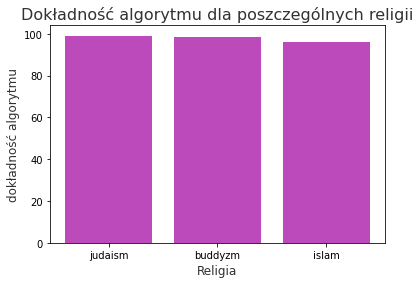

In [18]:
islam_good=0
judaism_good=0
buddyzm_good=0

for string in islam.Posts['clear_body']:
    if another_which_religion_with_stopwords(string, 6.8)=='islam':
        islam_good+=1
        
for string in judaism.Posts['clear_body']:
    if another_which_religion_with_stopwords(string, 6.8)=='judaism':
        judaism_good+=1
        
for string in buddyzm.Posts['clear_body']:
    if another_which_religion_with_stopwords(string, 6.8)=='buddyzm':
        buddyzm_good+=1
        
accuracy=[judaism_good/len(judaism.Posts)*100, buddyzm_good/len(buddyzm.Posts)*100, islam_good/len(islam.Posts)*100]
print(f'islam accuracy: {accuracy[2]}%')
print(f'judaism accuracy: {accuracy[0]}%')
print(f'buddyzm accuracy: {accuracy[1]}%')
show_accuracy(*accuracy)
        

In [19]:
best=0
for wsp in range(11,101):
    islam_good=0
    judaism_good=0
    buddyzm_good=0

    for string in islam.Comments['clear_text'][:3000]:
        if another_which_religion_with_stopwords(string, wsp/10)=='islam':
            islam_good+=1
        
    for string in judaism.Comments['clear_text'][:3000]:
        if another_which_religion_with_stopwords(string, wsp/10)=='judaism':
            judaism_good+=1
        
    for string in buddyzm.Comments['clear_text'][:3000]:
        if another_which_religion_with_stopwords(string, wsp/10)=='buddyzm':
            buddyzm_good+=1
    k= (islam_good+judaism_good+buddyzm_good)/3000
    if k>best:
        best=k
        best_wsp = wsp/10
print(f'najlepszy współczynnik to {best_wsp}')
print(f'osiągnął średnią skuteczność {best*100/3}% w ocenianu komentarzy')

najlepszy współczynnik to 4.2
osiągnął średnią skuteczność 78.73333333333333% w ocenianu komentarzy


islam accuracy: 96.28389053908867%
judaism accuracy: 98.25378346915018%
buddyzm accuracy: 98.68380110772294%


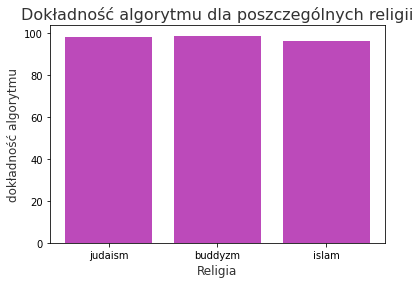

In [20]:
islam_good=0
judaism_good=0
buddyzm_good=0

for string in islam.Posts['clear_body']:
    if another_which_religion_with_stopwords(string, 4.2)=='islam':
        islam_good+=1
        
for string in judaism.Posts['clear_body']:
    if another_which_religion_with_stopwords(string, 4.2)=='judaism':
        judaism_good+=1
        
for string in buddyzm.Posts['clear_body']:
    if another_which_religion_with_stopwords(string, 4.2)=='buddyzm':
        buddyzm_good+=1
        
accuracy=[judaism_good/len(judaism.Posts)*100, buddyzm_good/len(buddyzm.Posts)*100, islam_good/len(islam.Posts)*100]
print(f'islam accuracy: {accuracy[2]}%')
print(f'judaism accuracy: {accuracy[0]}%')
print(f'buddyzm accuracy: {accuracy[1]}%')
show_accuracy(*accuracy)
        

islam accuracy: 70.4982115482882%
judaism accuracy: 94.01503029505284%
buddyzm accuracy: 78.567472306143%


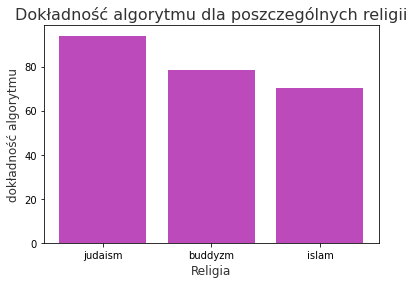

In [21]:
islam_good=0
judaism_good=0
buddyzm_good=0

for string in islam.Comments['clear_text']:
    if another_which_religion_with_stopwords(string, 4.2)=='islam':
        islam_good+=1
        
for string in judaism.Comments['clear_text']:
    if another_which_religion_with_stopwords(string, 4.2)=='judaism':
        judaism_good+=1
        
for string in buddyzm.Comments['clear_text']:
    if another_which_religion_with_stopwords(string, 4.2)=='buddyzm':
        buddyzm_good+=1

accuracy=[judaism_good/len(judaism.Comments)*100, buddyzm_good/len(buddyzm.Comments)*100, islam_good/len(islam.Comments)*100]
print(f'islam accuracy: {accuracy[2]}%')
print(f'judaism accuracy: {accuracy[0]}%')
print(f'buddyzm accuracy: {accuracy[1]}%')
show_accuracy(*accuracy)

In [22]:
string=rmtags('At the beginning of this week’s Torah portion Moses asks the Eternal to let him enter the Promised Land')
print(another_which_religion_with_stopwords(string, 4.2))
string=rmtags('His Holiness(aba) said that yesterday was 27th May which is known in the Community as Khilafat Day.')
print(another_which_religion_with_stopwords(string, 4.2))
string=rmtags("The Buddha's third sermon is about the three evils that afflict the beings and bind them to the cycle of births and deaths and suffering")
print(another_which_religion_with_stopwords(string, 4.2))

judaism
islam
buddyzm
